# Learning from networks project: Evaluation of different Node Embedding algorithms
Members:<br>
- D'Emilio Filippo, id : 2120931
- Volpato Pietro, id : 2120825

## Embedding evaluation notebook
Using this notebook you can evaluate the quality of the embeddings produced using the following metrics:
- Reconstruction error: measures the ability of reconstructing the original graph from the embedding vectors of the nodes.
- Node classification: train classifier to predict which class a node belongs to. The classifier uses as features the embedding vectors of the nodes (or quantities computed from them).
- Link prediction: train a classifier that, given a pair of node embeddings, predicts whether exist an edge between such nodes in the graph.
- Neighborhood preservation: quantifies the corrispondence between the neighborhood of a node in the embedding space and the actual neighborhood of a node in the graph.

In [34]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import gzip
import re
import os
import random
import math
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# configuration
Here you can properly configure the names of the graphs and the names of the embedding strategies.<br>
Set emb_dim = 128 to load 128-dimensional embeddings, set emb_dim = 256 to load 256-dimensional embeddings.

In [35]:
graph_keys = ["facebook","citation","biological","proteins", "spam"]
embedding_keys = ["LINE", "node2vec", "AW"]
emb_dim = 128

# Loading the embeddings
The embeddings should be saved in ../result folder as a .npy file.<br>
Embeddings are stored in a dictionary of dictionaries.<br>
The first index refer to the graph (e.g. embeddings["facebook"] contains the embeddings of the facebook graph for every embedding technique).<br>
The second index refer to the embedding technique (e.g. embeddings["facebook"]["LINE"] cointans the embedding of facebook graph computed using LINE)

In [44]:
def load(name):
    """
    Loads a NumPy array from a file. If the file is not found, 
    displays a warning and returns None.

    name (str): The name of the file (without extension) to load from the 'embeddings' directory.
    
    return: np.ndarray or None: The loaded NumPy array, or None if the file is not found.
    """
    file_name = f"../result/{name}.npy"
    if not os.path.exists(file_name):
        print(f"Warning: File '{file_name}' not found.")
        return None

    emb = np.load(file_name)
    print(f"Loaded {file_name} successfully")
    return emb

embeddings = {}
for k in graph_keys:
    embeddings[k] = {}

for graph_key in graph_keys:
    for emb_key in embedding_keys:
        s = f"embeddings_{graph_key}_{emb_key}_{emb_dim}"
        embeddings[graph_key][emb_key] = load(s)

Loaded ../result/embeddings_facebook_LINE_128.npy successfully
Loaded ../result/embeddings_facebook_node2vec_128.npy successfully
Loaded ../result/embeddings_facebook_AW_128.npy successfully
Loaded ../result/embeddings_citation_LINE_128.npy successfully
Loaded ../result/embeddings_citation_AW_128.npy successfully
Loaded ../result/embeddings_biological_LINE_128.npy successfully
Loaded ../result/embeddings_biological_node2vec_128.npy successfully
Loaded ../result/embeddings_biological_AW_128.npy successfully
Loaded ../result/embeddings_proteins_LINE_128.npy successfully
Loaded ../result/embeddings_proteins_node2vec_128.npy successfully
Loaded ../result/embeddings_proteins_AW_128.npy successfully
Loaded ../result/embeddings_spam_LINE_128.npy successfully
Loaded ../result/embeddings_spam_node2vec_128.npy successfully
Loaded ../result/embeddings_spam_AW_128.npy successfully


# Loading the graphs
Selected graphs:
- Facebook_combined    https://snap.stanford.edu/data/ego-Facebook.html          
- cit-Helpth           https://networkrepository.com/cit-HepTh.php             
- bio-CE-CX            https://networkrepository.com/bio-CE-CX.php             
- proteins-full        https://networkrepository.com/PROTEINS-full.php ---- the graph has node labels
- spam                 https://networkrepository.com/web-spam-detection.php  ---- the graph has node labels

To run this notebook, adjust the paths to match where the files are saved in your PC.<br>
To keep paths as they are, download the repository.<br>
Graphs are stored as a dictionary: the key is the graph name, the value is the corresponding netowrkx graph.<br>

When it is created a networkX graph from a text file the node are renamed as integers form 0 to |V|-1, so that we can store the embeddings
on a matrix, and each row index corresponds to the embedding vector of the corrisponding node.

In [37]:
facebook_path = '../data/facebook/facebook_combined.txt.gz'
citation_path = '../data/citation/cit-HepTh.edges'
biological_path = '../data/biological/bio-CE-CX.edges'
proteins_path = "../data/proteins/PROTEINS-full.edges"
spam_path = "../data/spam/web-spam-detection.edges"

proteins_labels_path = "../data/proteins/PROTEINS-full.node_labels"
spam_labels_path = "../data/spam/web-spam-detection.node_labels"
features_path = "../data/proteins/PROTEINS-full.node_attrs"  # node features, only proteins graph

In [38]:
def load_graph_edges(path):
    """
    For files with extension .edges
    nodes are renamed as integers, starting from 0
    """
    G = nx.Graph()
    with open(path, 'rt') as f:
        for line in f:
            if line.startswith('%'):  # Skip comment lines
                continue
            # Split the line based on spaces or commas
            data = re.split(r'[,\s]+', line.strip())
            if len(data) < 2:  # Skip lines that don't have at least two columns
                continue
            # Extract the first two columns (nodes)
            node1, node2 = int(data[0]), int(data[1])
            G.add_edge(node1, node2)
        
    return relabel_get_mapping(G)

def load_graph_with_gz(path):
    """
    For files with extension .txt.gz
    nodes are renamed as integers, starting from 0
    """
    G = nx.Graph()
    with gzip.open(path, 'rt') as f:
        for line in f:
            node1, node2 = map(int, line.strip().split())
            G.add_edge(node1, node2)
            
    return relabel_get_mapping(G)

def print_graphs_info(graphs):
    for k in graph_keys:
        G = graphs[k]
        print(f"{k}: |V|={len(G.nodes)}, |E|={len(G.edges)}")

def relabel_get_mapping(G):
    """
    Given a graph G, this function returns a graph where the nodes are relabeled as integers, form 0 to |V|-1.
    It is also returned the mapping from original name to relabeled name.
    """
    inverse_mapping = {i : node for i,node in enumerate(G.nodes)} # mappoing new_name : original_name
    direct_mapping = {node : i for i,node in enumerate(G.nodes)} # mapping original_name : new_name
    G = nx.relabel_nodes(G, direct_mapping)
    return G, direct_mapping

In [39]:
graphs = {}  # dictionary containg the graphs
mappings = {} # dictionary to contain the mappings. Original name : relabeled name
for k in graph_keys:
    mappings[k] = {}
    
# facebook graph is the only one .tar.gz        
graphs[graph_keys[0]], mappings[graph_keys[0]] = load_graph_with_gz(facebook_path) 
graphs[graph_keys[1]], mappings[graph_keys[1]] = load_graph_edges(citation_path)
graphs[graph_keys[2]], mappings[graph_keys[2]] = load_graph_edges(biological_path)
graphs[graph_keys[3]], mappings[graph_keys[3]] = load_graph_edges(proteins_path)  # node labeled
graphs[graph_keys[4]], mappings[graph_keys[4]] = load_graph_edges(spam_path)  # node labeled

print_graphs_info(graphs)

facebook: |V|=4039, |E|=88234
citation: |V|=22908, |E|=2444798
biological: |V|=15229, |E|=245952
proteins: |V|=43471, |E|=81049
spam: |V|=9072, |E|=473854


## Extract the labels
The graphs "proteins" and "spam" have node labels. <br>
In the text file containing the labels each line has only one number (corresponding class), and such element refers implicitly to the line number node, according to the original node names definition.<br>
Since when we load a graph we rename node as integers starting from 0, the mapping is applied to match each label with the correct node according
to the modified node names.<br>

In [31]:
def load_node_labels(file_path, graph_key):
    """
    Reads a file containing node labels and returns a dictionary mapping nodes to labels.
    The labels are assumed to be listed in sequential order: first label is relative to first node (according to original name), and so on...

    Parameters: file_path (str): Path to the node label file.
                graph_key : key of the graph, needed for the mappings between original and renamed nodes.
    

    Returns:
        node_labels (dict): A dictionary where keys are oroginal node names, values are their corresponding labels.
    """
    node_labels = {}
    with open(file_path, 'r') as file:
        i = 1 # keep track of incedes of original names because bad CL fata format
        for line in file:
            line = line.strip()  # Remove leading/trailing whitespace
            if not line:  # Skip empty lines
                continue

            # i is the node original name, but labels skip nodes that are isolated
            map = mappings[graph_key]
            while i not in map.keys():  # skip isolated nodes
                i += 1
            
            real_name = map[i]
            label = int(line)  # Parse the labels
            node_labels[real_name] = label  # Map the line number (node ID) to the label
            i += 1

    return node_labels

labels = {}
labels["proteins"] = load_node_labels(proteins_labels_path, "proteins")
labels["spam"] = load_node_labels(spam_labels_path, "spam")

## 2D visualization of the embeddings
Using PCA or tsne is possible to visualize the embedding vectors in a 2D space.<br>
This might be useful to have an idea of the embedding vectors distribution.

In [55]:
def visualize_embeddings(embeddings, labels=None, method="tsne", random_state=69):
    """
    Visualize embeddings in 2D space using t-SNE or PCA.
    
    Parameters:
        embeddings (np.ndarray): Embedding matrix of shape (n_nodes, dimensions).
        labels (list or np.ndarray): Optional, class labels for nodes. Used for coloring.
        method (str): Dimensionality reduction method ("tsne" or "pca").
        random_state (int): Random state for reproducibility.
        
    """
    if method == "tsne":
        reducer = TSNE(n_components=2, random_state=random_state, init='random', perplexity=30)
        reduced_embeddings = reducer.fit_transform(embeddings)
    elif method == "pca":
        reducer = PCA(n_components=2, random_state=random_state)
        reduced_embeddings = reducer.fit_transform(embeddings)
    else:
        raise ValueError("Method must be 'tsne' or 'pca'")
    
    plt.figure(figsize=(10, 7))
    if labels is not None:
        scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='tab10', s=10, alpha=0.8)
        plt.legend(*scatter.legend_elements(), title="Classes", loc="upper right", fontsize="small", markerscale=2)
    else:
        plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=10, alpha=0.8)
    
    plt.title(f"2D Visualization of Embeddings using {method.upper()}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

## Choose the embeddings you want to visualize

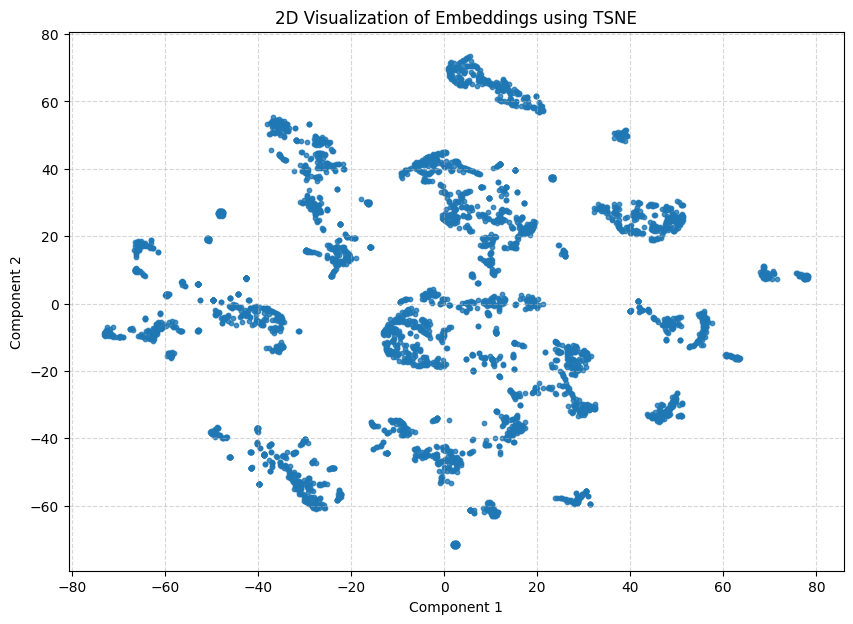

In [56]:
# CHOOSE
graph_key = "facebook"
embedding_key = "AW"
mathod = "tsne"

lab = None
if graph_key in ["proteins","spam"]: 
    # sort the labels in a list to visualize node classes colors
    lab = []
    for i in range(len(labels[graph_key])):
        lab.append(labels[graph_key][i])
        
visualize_embeddings(embeddings[graph_key][embedding_key], lab, method = mathod)

# Reconstruction error
The reconstruction error measures the ability of reconstructing the original graph using the node embedding vectors.<br>
Reconstruct the connections between nodes given the embeddings is not trivial, since different embedding techniques may produce the embedding vectors in very different ways, hence the best way to reconstruct the graph vary with the embedding strategy considered.<br>
Doing an exact computation of the reconstruction error implies to scan all possible pair of nodes, which is computationally infeasible for large graphs (10^5 nodes ----> 10^10 computation of similarities between pair of 128-dimensional vectors).<br>
To solve the computational complexity problem, we developed a simple approximation algorithm. <br>
First of all, we need to define a similarity function, that given the embeddings of two nodes, returns the similarity of those w.r.t. a define measure (e.g. cosine similarity, Euclidean distance). Note that a similarity measures might be optimal for an embedding strategy, and meaningless for another embedding strategy.<br>
The approximate_reconstruction_error() is a very simple algorithm based on sampling, and can be summaryzed in two steps:
1) Draw positive and negative samples to define a threshold, which will be the criterion to "guess" if, given pair of embedding vectors, there is an edge in the graph.
2) Draw new positive and negative samples, use the similarity function and apply the threshold to such value to make the predictions. Then the reconstruction error is defined as the number of errors divided by the number of samples. Note that an error can be a FP: guess a non-existing edge, or a FN: missed to guess an existing edge.

INPUT:
- G=(V,E) undirected graph
- embeddings: matrix of embeddings, embeddings[i] is the embedding vector of node i
- sim_function: a function returning the similarity of two vectors. Assumption: higher (with sign) value represents higher similarity.

OUTPUT: approximated RE of G with given embeddings
<pre>
approximate_reconstruction_error(G, embeddings, sim_function)

N <--- int(ln(|E|)^3.5)
{draw samples to define the threshold}
positive_edges <---- draw uniformly at random N edges
negative_edges <---- draw uniformly at random N pair of nodes for which does not exist an edge in the graph
sim_pos <---- average similarity of all pair of nodes in positive_edges
sim_neg <---- average similarity of all pair of nodes in negative_edges
threshold <---- (sim_pos+sim_neg)/2
{draw samples to reconstruct the graph}
positive_edges <---- draw uniformly at random N edges
negative_edges <---- draw uniformly at random N pair of nodes for which does not exist an edge in the graph
samples <---- [positive_edges,negative_edges]
errors <---- 0
for each (u,v) in samples:
    prediction <--- True if sim_function(embeddings[u],embeddings[v])>= threshold, False otherwise
    compare the prediction with the actual presence of edge (u,v) in the graph, and update error counter
return errors/|samples|
</pre>

The reconstruction error is in the interval [0,1]. RE = 1 means that (approximately) we are able to perfectly reconstruct the original graph given the embedding vectors. <br>
NOTES:
- We are free to choose the similarity function that is more meaningful w.r.t. the embedding strategy, for example the cosine similarity works perfectly with LINE embeddings, but very poorly for node2vec or Attention Walk. This is because of how the embeddings are generated: LINE embeddings are optimized to explicitly preserve proximity between nodes, making cosine similarity a natural measure of similarity. For other methods like Node2Vec and Attention Walk, the embeddings might encode other structural properties that cosine similarity fails to capture.
- The computation of the reconstruction error might seem similar to a link prediction task, but there is a big key difference: in link prediction we are training a model providing examples, constituted by the features and the ground truth (1 = edge, 0 = no edge). During the computation of the RE instead we are only using the embeddings trying to guess the presence of edges, without ever having any information of the ground truth.

In [41]:
def similarity_function(x,y, f = "euclidean distance"):
    if f == "cosine similarity":
        return cosine_similarity(x.reshape(1, -1), y.reshape(1, -1))[0, 0]
    if f == "euclidean distance":
        return -np.linalg.norm(x - y)  # since the returned value is interpreted as a similarity, - sign
    
def approximate_reconstruction_error(
    G,
    embeddings,
    sim_function = "euclidean distance",
    threshold_function = lambda a,b: (a + b)/2
):
    """
    Computes an approximate reconstruction error for a graph embedding.
    
    Parameters:
        G (nx.Graph): Input graph.
        embeddings (np.ndarray): Embedding matrix (n_nodes x dimensions).
        sim_function: defines what metric is used to establish the similarity between two embedding vectors
        threshold_function defines how is computed the threshold from sim_neg = a, sim_pos = b
    
    Returns:
        dict: Reconstruction error and additional statistics (e.g., FP, FN).
    """
    if sim_function not in ["cosine similarity", "euclidean distance"]:
        print("Possible values of sim_function: cosine similarity, euclidean distance")
        return None
        
    nodes = list(G.nodes())
    n_samples = int(math.log(len(G.edges))**3.5)

    # pick the samples to compute average cosine similarity of positive and negative edges
    positive_edges = random.sample(list(G.edges()), n_samples)
    negative_edges = []
    while len(negative_edges) < len(positive_edges):
        u, v = random.sample(nodes, 2)
        if not G.has_edge(u, v) and (u, v) not in negative_edges and (v, u) not in negative_edges:
            negative_edges.append((u, v))
            
    # average cos sim for existing edges
    sim_pos = np.mean([similarity_function(embeddings[u], embeddings[v], sim_function) for u,v in positive_edges])
    sim_neg = np.mean([similarity_function(embeddings[u], embeddings[v], sim_function) for u,v in negative_edges])

    # define threshold for reconstruction of the graph
    threshold = threshold_function(sim_neg, sim_pos)
    
    # pick new fresh samples to approximate the reconstructon ability of the graph
    positive_edges = random.sample(list(G.edges()), n_samples)
    negative_edges = []
    while len(negative_edges) < len(positive_edges):
        u, v = random.sample(nodes, 2)
        if not G.has_edge(u, v) and (u, v) not in negative_edges and (v, u) not in negative_edges:
            negative_edges.append((u, v))

    errors = 0
    fp = 0
    fn = 0
    samples = positive_edges + negative_edges  # concatenate the samples
    for u,v in samples:
        sim = similarity_function(embeddings[u], embeddings[v], sim_function)
        prediction = True if sim >= threshold else False
        if prediction == True and not G.has_edge(u, v):  # false positive
            errors+=1
            fp+=1
        if prediction == False and  G.has_edge(u, v):  # false positive
            errors+=1
            fn+=1
    re = errors/len(samples)
    fp_rate = fp/len(samples)
    fn_rate = fn/len(samples)
    return {
        "re": re,
        "fp_rate": fp_rate,
        "fn_rate": fn_rate,
        "sim_pos": sim_pos,
        "sim_neg": sim_neg
    }
    
def print_reconstruction_error(dict, graph_name , embedding_technique, sim_function, show_all):
    re = dict["re"]
    fp_rate = dict["fp_rate"]
    fn_rate = dict["fn_rate"]
    sim_pos = dict["sim_pos"]
    sim_neg = dict["sim_neg"]
    if show_all:
        s = f"RE ({sim_function}) of {graph_name} using {embedding_technique} = {re:.4f}. FP rate = {fp_rate:.4f}. FN rate = {fn_rate:.4f}. "
        s += f"avg_pos = {sim_pos:.4f}, avg_neg = {sim_neg:.4f}"
        print(s)
    else:
        print(f"RE of {graph_name} using {embedding_technique} = {re:.4f}")
        
def compute_all_reconstruction_errors(graph_keys, embedding_keys, f_dict, thresholds_dict, show_all = True):
    for emb_key in embedding_keys:
        for graph_key in graph_keys:
            G = graphs[graph_key]
            E = embeddings[graph_key][emb_key]
            sim_function = f_dict[emb_key]  # associate the similarity function
            threshold_function = thresholds_dict[emb_key]  # associate the threshold function
            if  E is not None and E.size != 0:
                dict = approximate_reconstruction_error(
                    G, E, sim_function = sim_function, threshold_function = threshold_function
                )
                print_reconstruction_error(dict, graph_key, emb_key, sim_function, show_all = show_all)

## Compute the RE
Here you can compute the reconstruction error.<br>
- Set graph_keys_RE with the keys of the graphs you are interested. graph_keys_RE = graph_keys for all graphs.<br>
- set embedding_keys_RE with the keys of the embedding strategies you are interested. graph_keys_RE = embedding_keys for all embedding strategies.<br>

In [62]:
# chose the similarity function for each embedding strategy. this choice has a big impact on the results.
f_dict = {
    "LINE" : "cosine similarity",
    "AW" : "euclidean distance",
    "node2vec" : "euclidean distance"
}

thresholds_dict = {
    # a will be sim_neg, b will be sim_pos. Assume sim_neg < sim_pos
    "LINE" : lambda a,b: (a + b)/2,   # good threshold for line is a simple average 
    "AW" : lambda a,b: (a + b)/2, # threshold for AW is more than the average (otherwise too many FP) a + (b - a)*1/4,
    "node2vec" : lambda a,b: (a + b)/2
}

# CHOOSE
graph_keys_RE = ["facebook", "biological", "citation", "proteins", "spam"]
#embedding_keys_RE = ["node2vec", "LINE", "AW"]
embedding_keys_RE = ["LINE"]
show_all = True

compute_all_reconstruction_errors(graph_keys_RE, embedding_keys_RE, f_dict, thresholds_dict, show_all = show_all)

RE (cosine similarity) of facebook using LINE = 0.0280. FP rate = 0.0093. FN rate = 0.0187. avg_pos = 0.6235, avg_neg = -0.0043
RE (cosine similarity) of biological using LINE = 0.0415. FP rate = 0.0203. FN rate = 0.0212. avg_pos = 0.4682, avg_neg = 0.0204
RE (cosine similarity) of citation using LINE = 0.1016. FP rate = 0.0412. FN rate = 0.0604. avg_pos = 0.4734, avg_neg = 0.0136
RE (cosine similarity) of proteins using LINE = 0.0163. FP rate = 0.0001. FN rate = 0.0162. avg_pos = 0.7602, avg_neg = -0.0009
RE (cosine similarity) of spam using LINE = 0.1032. FP rate = 0.0411. FN rate = 0.0621. avg_pos = 0.3807, avg_neg = -0.0014


# NODE CLASSIFICATION

## Analysis of the datasets
It is always a good idea to have a look at the datasets we are dealing with.<br>
- features are the embeddings of the nodes, which is an D-dimensional vector, where D (e.g. 128) is the dimension of the specific embeddings
we are using to training.
- the labels represent the classes of the nodes. We can analyze the labels set to see how many different classes there are and understand how balanced the dataset is.

In [120]:
def analyze_labels(labels):
    labels_count = {}
    for label in labels.values():
        if not label in labels_count.keys():
            labels_count[label] = 0
        labels_count[label] += 1
    print(f"Number of samples: {len(labels)}")
    print(f"Number of classes: {len(labels_count)}")
    for label in labels_count.keys():
        print(f"Samples of class {label}: {labels_count[label]}")

print("INFO DATASET PROTEINS GRAPH")
analyze_labels(labels["proteins"])

print("INFO DATASET SPAM GRAPH")
analyze_labels(labels["spam"])

INFO DATASET PROTEINS GRAPH
Number of samples: 43471
Number of classes: 3
Samples of class 0: 21151
Samples of class 1: 20931
Samples of class 2: 1389
INFO DATASET SPAM GRAPH
Number of samples: 9072
Number of classes: 3
Samples of class 2: 6365
Samples of class 1: 594
Samples of class 3: 2113


## Train and evaluate the model
A support vector machine is trained from the dataset provided in input.<br>
Class weights are used to handle the case of an imbalance dataset (some classes have considerably less examples than others).<br>
The model is trained on 80% of the dataset (training set), while 20% of the dataset (test set) is left to make predictions and evaluate the performances of the classifier.

In [22]:
def train_balanced_classifier(embeddings, labels):
    """
    Train and evaluate a balanced classifier for multi-class node classification.

    Parameters:
        embeddings (np.ndarray): Numpy array where each row is a node's embedding.
        labels (dict): Dictionary mapping node indices to their labels.

    """
    # Ensure X (features) and y (labels) are aligned
    X = np.array(embeddings)  # Node embeddings
    scaler = StandardScaler()
    X = scaler.fit_transform(X)  # Normalize embeddings
    y = np.array([labels[i] for i in range(len(labels))])  # Ensure correct ordering of labels

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

    # Initialize the classifier
    clf = SVC(kernel='rbf', class_weight = 'balanced', decision_function_shape='ovo')    
    clf.fit(X_train, y_train)

    # Predict and evaluate on training set
    y_train_pred = clf.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred, average='macro')
    train_report = classification_report(y_train, y_train_pred)

    # Predict and evaluate on test set
    y_test_pred = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    test_report = classification_report(y_test, y_test_pred)

    # Print results
    print("Training Results:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Training Macro F1-Score: {train_f1:.4f}")
    #print("Training Classification Report:\n", train_report)

    print("Test Results:")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Macro F1-Score: {test_f1:.4f}")
    print("Test Classification Report:\n", test_report)


## Choose the graph and the embedding strategy to train the model
The graphs with node labels are "proteins" and "spam"

In [23]:
# CHOOSE
embedding_key = "AW"
graph_key = "spam"  # proteins or spam

E = embeddings[graph_key][embedding_key]
y = labels[graph_key]

x = train_balanced_classifier(E, y)

Training Results:
Training Accuracy: 0.4786
Training Macro F1-Score: 0.4009
Test Results:
Test Accuracy: 0.4022
Test Macro F1-Score: 0.2995
Test Classification Report:
               precision    recall  f1-score   support

           1       0.06      0.10      0.08       134
           2       0.68      0.42      0.52      1258
           3       0.22      0.43      0.30       423

    accuracy                           0.40      1815
   macro avg       0.32      0.32      0.30      1815
weighted avg       0.53      0.40      0.44      1815



## Train a model using real node attributes as features
This can be done only for "proteins" graph, which is the only dataset with node attributes.<br>
We train a model using as features the real node attributes (knowledge of quantities in considered domain).<br>
We expect the following model to perform better than a model training using only the embedding vectors as features, since:
- The embeddings are produced using only information about the network. (connections between nodes)
- The node attributes represents real-world measured quantites relative to a node. (domain knowledge)

It is reasonable that the attributes of a node are a better representation than the embedding vector, since we are dealing with a node classification task 

In [9]:
def extract_attributes(path, map):
    with open(path, 'r') as file:
        i = 1
        features_dict = {}
        for line in file:
            # Split the line based on spaces or commas
            node_features = np.array(re.split(r'[,\s]+', line.strip()))
            # mapping needed to correctly match features with the renaming of the nodes
            real_name = map[i]
            features_dict[real_name] = node_features 
            i += 1
    features = np.array([features_dict[i] for i in range(len(features_dict))]) # node-sorted numpy array
    return features

In [72]:
X = extract_attributes(features_path, mappings["proteins"])
y = labels["proteins"]

train_balanced_classifier(X, y)  # we train same classifier, but using node attributes

KeyboardInterrupt: 

## Train a model combining attributes and embedding vectors as features
Even if node attributes are more powerful than embedding vectors for a node classification task, it might be that using as features both the node attributes and the embedding vectors we are able to produce a classifier that performs better than the two separate cases.

In [10]:
emb_key = "node2vec"  # chose the embedding strategy

E = embeddings["proteins"][emb_key]
X = extract_attributes(features_path, mappings["proteins"])
y = labels["proteins"]

combined_features = np.zeros((X.shape[0], X.shape[1]+E.shape[1])) # concatenation of node attributes and embedding vectors

for i in range(combined_features.shape[0]):  # for each row
    combined_features[i] = np.concatenate((X[i], E[i]))  # concatenate node attributes and node embeddings
    
train_balanced_classifier(combined_features, y)  

Training Results:
Training Accuracy: 0.9007
Training Macro F1-Score: 0.8410
Test Results:
Test Accuracy: 0.8719
Test Macro F1-Score: 0.8164
Test Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88      4209
           1       0.88      0.87      0.88      4226
           2       0.53      0.98      0.69       260

    accuracy                           0.87      8695
   macro avg       0.77      0.91      0.82      8695
weighted avg       0.88      0.87      0.87      8695



# LINK PREDICTION
The link prediction task consists on training a model, logistic regression in this case, that given as input the features of a pair of nodes predicts whether the edge between them exists in the graph or not.<br>

## PRODUCING THE DATASET
We decided to produce a perfectly balanced dataset in this way: all the positive examples are all the pair of nodes (actually the features we decided to use to represent them) for which exists an edge in the graph.<br>
The negative examples instead are created by chosing at random a pair of nodes, and if there is no edge between them such pair is a negative example. We repeat this procedure until the number of negative examples matches the number of positive examples<br>

We defined 3 possible choices for the features representing pair of nodes:
- The concatenation of the embeddings of the two nodes
- The concatenation of the embeddings + the similarity between those (a scalar)
- Just the scalar similarity between the two embeddings

In [49]:
def create_link_prediction_dataset(G, embeddings, sim_function = None, only_sim_function = False):
    """
    Creates a dataset for link prediction. 

    Parameters:
        G (nx.Graph): The input graph.
        embeddings (np.ndarray): Node embeddings as a numpy array (indexed by node ID).
        sim_function: lambda function computing the similarity scalar between two embeddings.
                      if sim_function is not none, the similarity is added as feature (+1 features dimension)
        only_sim_function: if True the features are just the scalar representing the similarity between the two embedding vectors.

    Returns:
        X (np.ndarray): Features.
        y (np.ndarray): Labels (1 for existing edges, 0 for non-existing edges).
    """
    if only_sim_function and sim_function is None:
        print("You set only_sim_function = True, but no similarity function provided")
        return None
        
    positive_edges = list(G.edges())
    num_positive = len(positive_edges)

    # Generate negative edges
    nodes = list(G.nodes())
    negative_edges = set()
    while len(negative_edges) < num_positive:
        u, v = random.sample(nodes, 2)
        if not G.has_edge(u, v) and (u, v) not in negative_edges and (v, u) not in negative_edges:
            negative_edges.add((u, v))

    # Combine positive and negative edges
    all_edges = positive_edges + list(negative_edges)
    labels = [1] * len(positive_edges) + [0] * len(negative_edges)

    # Create features from embeddings
    X = []
    for u, v in all_edges:       
        u_emb = embeddings[u].reshape(1, -1)
        v_emb = embeddings[v].reshape(1, -1)
        
        if only_sim_function:  # features are only cosine similarities (scalar)
            sim = sim_function(u_emb, v_emb)
            X.append(sim)
            
        else:  # features are concatenation of embeddings and eventually also the cosine similarity            
            if sim_function is not None:         
                sim = sim_function(u_emb, v_emb)
                feature = np.concatenate([embeddings[u], embeddings[v], [sim]]) # Concatenate embeddings and cosine similarity
            else:
                feature = np.concatenate([embeddings[u], embeddings[v]]) # concatenate the embeddings
            X.append(feature)
            
    X = np.array(X).reshape(-1, 1) if only_sim_function else np.array(X)        
    y = np.array(labels)
    return X, y

## TRAIN LOGISTIC REGRESSION CLASSIFIER

In [50]:
def LR_link_prediction(X,y):
    """
    Train a logistic regression classifier for link prediction
    """
    scaler = StandardScaler()
    X = scaler.fit_transform(X)  # normalization
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

    # Train logistic regression model
    clf = LogisticRegression(max_iter = 2000)
    clf.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = clf.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
    print("Classification Report:\n", classification_report(y_test, y_pred))

In [51]:
embedding_key = "AW"
graph_key = "facebook"

# dictionary mapping embedding keys to proper similarity functions
sim_f_dict = {
    "LNE" : lambda a,b: cosine_similarity(a.reshape(1, -1), b.reshape(1, -1))[0, 0],
    "AW" : lambda a,b: -np.linalg.norm(a - b),
    "node2vec" : lambda a,b: -np.linalg.norm(a - b)
}

f = sim_f_dict[embedding_key] if embedding_key in sim_f_dict.keys() else None  # avoid key errors
only_sim_function = False

G = graphs[graph_key]
E = embeddings[graph_key][embedding_key]
X,y = create_link_prediction_dataset(G, E, sim_function = f, only_sim_function = only_sim_function)

LR_link_prediction(X,y)

Accuracy: 0.9771065903553012
ROC AUC Score: 0.9946421707862159
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98     17646
           1       0.97      0.99      0.98     17648

    accuracy                           0.98     35294
   macro avg       0.98      0.98      0.98     35294
weighted avg       0.98      0.98      0.98     35294



# Neighborhood preservation
To compute the top-k nearest neighbors (k-NN) we use FAISS (Facebook AI Similarity Search), which is an approximation algorithm to compute the k-NN for each node in the graph. Since we are evaluating neighborhood preservation of the embeddings, we excluded from the top-k list the node itself (FAISS include by default the node itself as its nearest neighbor).<br>
The neighborhood preservation score is defined as follow:<br>

INPUT:
- G = (V,E): undirected graph
- embeddings: numpy array, where embeddings[i] is the embedding vector of node i in G
- k: for each node are extracted the top-k neighbors in the embedding space
- order: can be either 1 or 2. The neighborhood of u G is defined as the set of nodes reachable from u with a path of lenght "order" (1 or 2)

OUTPUT: neighborhood preservation score

<pre>
neighborhood_preservation_score(G, embeddings, k, order)
    
extract top-k neighbors in embedding space using FAISS for each node in V
for each node v in V:
    let i be the order of neighborhood considered
    let Nv be the set of i-th order neighborhood of v
    let k-NNv be the set of top-k nearest neighbors of v in the embedding space (euclidean distance)
    overlap <---- |Nv INTERSECTION k-NNv|
    normalization <---- MIN{|Nv|, k}   (k = |k-NNv|)
    score(v) <---- overlap / normalization
n_p_score <---- (sum of score(v) for all v in V) / |V|
return n_p_score
</pre>

The returned score is always in the interval [0,1]. The goal of the neighborhood preservation score is to have a an ojbective quantity
that tells if the neighbors of the nodes in the embeddings space match with the actual neighbors of the nodes in the graph. 
<br>

Consider a node v.
- if |Nv| <= k ( MIN = |Nv|), then the score represents how many nodes in Nv are also in k-NNv. (1 = all |Nv| nodes, 0 = none)
- if |Nv| > k ( MIN = k), then the score represents how many nodes in k-NNv are also in Nv. (1 = all k nodes, 0 = none)


In [47]:
import faiss

def get_k_nearest_neighbors(embeddings, k = 5, index_type = "L2"):
    if index_type not in ["L2", "cosine"]:
        raise ValueError("index_type can be 'L2' or 'cosine'")
    dimension = embeddings.shape[1]
    if index_type == "cosine": 
        embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
        # Use IndexFlatIP for cosine similarity
        index = faiss.IndexFlatIP(dimension)
    if index_type == "L2":
        index = faiss.IndexFlatL2(dimension)
    
    index.add(embeddings)
    # Query for top-k nearest neighbors
    distances, indices = index.search(embeddings, k + 1)  # Query for k+1 neighbors
    top_k_neighbors = [ind[1:] for ind in indices]  # Exclude self (first neighbor)
    return top_k_neighbors
    
def neighborhood_preservation_score(G, E, k = 5, order = 1, index_type = "L2"):
    if order not in [1,2]:
        raise ValueError("Order must be either 1 (first order neighborhood) or 2 (second order neighborhood)")
    if index_type not in ["L2", "cosine"]:
        raise ValueError("index_type can be 'L2' or 'cosine'")

    top_k_neighbors = get_k_nearest_neighbors(E, k=k, index_type = index_type)
    scores = []
    for v in G.nodes():
        Nv = set(G.neighbors(v))
        if order == 2:
            for u in G.neighbors(v):
                Nv = Nv.union(set(G.neighbors(u)))
        k_NN = set(top_k_neighbors[v])
        overlap = len(Nv & k_NN)
        normalization = min(len(Nv), k)
        scores.append(overlap/normalization)
    return np.mean(scores)

In [68]:
g_keys = ["facebook", "citation", "biological", "proteins", "spam"]
#e_keys = ["node2vec", "LINE", "AW"]
e_keys = ["node2vec"]
order = 1
k = 5

indeces_dict = {
    "LINE" : "cosine",
    "AW" : "L2",
    "node2vec" : "L2"
}

for ek in e_keys:  
    index_type = indeces_dict[ek]
    for gk in g_keys:
        G = graphs[gk]
        E = embeddings[gk][ek]
        if  E is not None and E.size != 0:        
            score = neighborhood_preservation_score(G, E, k = k, order = order, index_type = index_type)
            print(f"Order {order} neighborhood preservation score of {gk} with {ek}: {score}")

Order 1 neighborhood preservation score of facebook with node2vec: 0.8352067343401833
Order 1 neighborhood preservation score of biological with node2vec: 0.960288484689299
Order 1 neighborhood preservation score of proteins with node2vec: 0.8353565212057081
Order 1 neighborhood preservation score of spam with node2vec: 0.7244672251616696


# Clustering
Using k-means, we cluster the embedding space. We raccomend to use "facebook" graph, since it is the dataset where clustering is more meaningful.<br>
We can then evaluate the clustering:
- It is possible to see a plot of the graph, using networkX, where all the nodes of the same cluster are colored the same.
- We compute the modularity of the clustering for an ojbective evaluation.

In [66]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.preprocessing import StandardScaler
from networkx.algorithms.community import modularity

def cluster_embeddings(embeddings, k=5):
 
    # Normalize embeddings
    scaler = StandardScaler()
    embeddings = scaler.fit_transform(embeddings) 
    clusterer = KMeans(n_clusters=k, random_state=21)
    # Fit and predict
    cluster_labels = clusterer.fit_predict(embeddings)

    # Evaluate clustering with modularity
    clustering = []
    for i in range(k):
        clustering.append(set())  # clustering is a list of sets

    for i, cluster in enumerate(cluster_labels):
        clustering[cluster].add(i) # add to the set of the cluster the node (which is the index of cluster_labels)

    modularity_score = modularity(G, clustering)
    return cluster_labels, modularity_score

def visualize_clustering(G, embeddings, cluster_labels):
    
    # Create a color map for clusters
    unique_labels = np.unique(cluster_labels)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    color_map = {label: color for label, color in zip(unique_labels, colors)}

    # Assign colors to nodes based on their cluster labels
    node_colors = [color_map[cluster_labels[node]] for node in G.nodes()]

    # Draw the graph
    pos = nx.spring_layout(G, seed=42)  # Use spring layout for visualization
    plt.figure(figsize=(12, 12))
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=20, alpha=0.8)
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    plt.title("Graph Clustering Visualization", fontsize=16)
    plt.axis("off")
    plt.show()

C:\Users\oppil\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Modularity of clustering: 0.7834351203807833


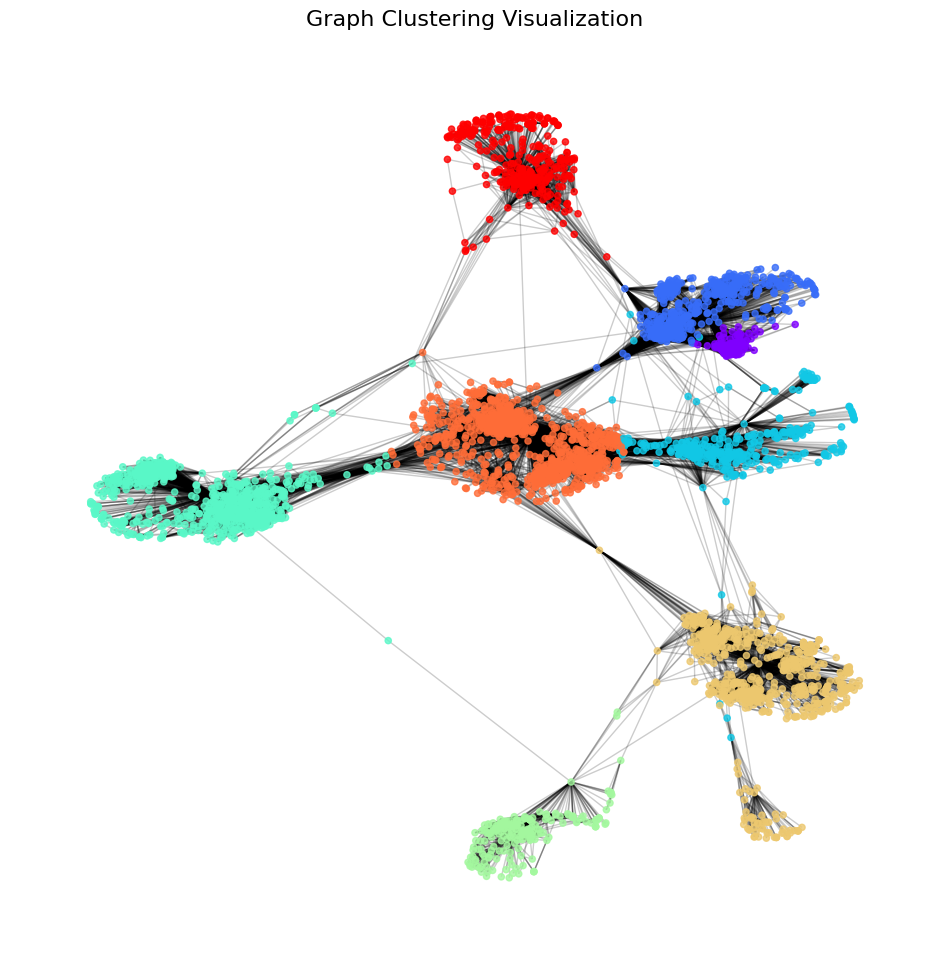

In [67]:
gk = "facebook"
ek = "AW"

G = graphs[gk]
E = embeddings[gk][ek]
cluster_labels, mod = cluster_embeddings(E, k = 8)
print(f"Modularity of clustering: {mod}")
#visualize_embeddings(E, labels=results["cluster_labels"], method="tsne")
visualize_clustering(G, E, cluster_labels)